In [33]:
import numpy as np 
import pandas as pd 
import os

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import torch.nn as nn
#from tensorflow.keras import activations, optimizers, losses


In [34]:
#!pip install rapidfuzz

In [35]:
from rapidfuzz.distance import Levenshtein

In [36]:
model_dir = "/finetuned_model/model_bart"
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

In [37]:
df = pd.read_parquet('15k_small_test_ds_new.parquet')

In [38]:
if torch.cuda.is_available():
    # Get GPU device name
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU: {gpu_name}")
else:
    print(":( no gpu for u)")

GPU: NVIDIA GeForce RTX 4070


In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): La

### Дальше -- сделать для основного инференса и пропустить для маленького 

In [40]:
import matplotlib.pyplot as plt 
from statistics import median, mean

In [41]:
# находим уникальные теги
def get_unique_tags(df):
    uniques={}
    for tags in zip(df['tags']):
        # tags это тьюплы с одним элементом -- листом в виде строки
        # т.ч. сначала эту строку достаём
        # а потом literal_eval для того чтобы это было уже норм листом
        #print(tags[0])
        for tag in tags[0]:
            if tag in uniques:
                uniques[tag]+=1
            else: uniques[tag]=1
    return uniques

In [42]:
un=get_unique_tags(df)
len(un)

1059

In [43]:
# если хотя бы в 3% записей этот тэг есть
major_tags={key:value for key,value in un.items() if value>(len(df)*0.03)}

In [44]:
major_tags

{'integration': 844,
 'real-analysis': 1388,
 'general-topology': 458,
 'abstract-algebra': 732,
 'calculus': 1693,
 'linear-algebra': 1097,
 'probability': 769,
 'algebra-precalculus': 742,
 'number-theory': 501,
 'trigonometry': 451,
 'sequences-and-series': 808,
 'combinatorics': 551,
 'elementary-number-theory': 602,
 'matrices': 470,
 'limits': 645,
 'complex-analysis': 471}

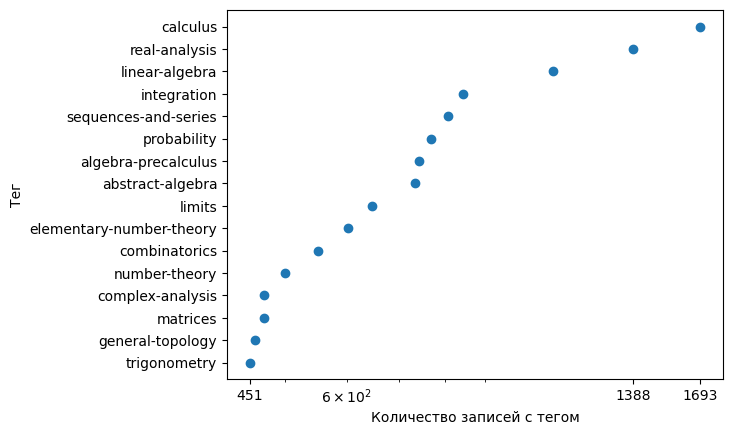

In [45]:
lists = sorted(major_tags.items(),key=lambda x:x[1]) 

y, x = zip(*lists)

fig, ax = plt.subplots()
ax.yaxis.set_tick_params(labelsize=10) 
plt.scatter(x, y)
plt.xlabel('Количество записей с тегом')
plt.ylabel('Тег')
plt.xscale('log')
# ticks = [min(major_tags.values()),round(median(major_tags.values())), lists[-2][1], max(major_tags.values())] 
ticks = [min(major_tags.values()),lists[-2][1], max(major_tags.values())] 
tick_labels = [f'{val}' for val in ticks]

#ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.xticks(ticks, tick_labels)
plt.show()

In [46]:
df.head()

,text_id,output_texts,input_texts,tags,augmentation,formulae_only
13875,141055,$$V^2 \;\;\text{is proportional to}\;\; (xy)^3...,V в степени 2 \;\;\text{is proportional to}\;\...,"[integration, geometry, conic-sections]",all_augments,True
2995,582037,"Похоже, Эванс просто применяет определение яко...","Похоже, Эванс просто применяет определение яко...",[pde],rand_delet_and_typo,False
13143,588904,"Вы только доказали, что $\overline A\cup\overl...","Вы только доказали, что $\overline А \cup\ove...","[real-analysis, general-topology]",synonyms,False
2326,185847,"$h | d_i : d_i \to \bar B(a,r)$","h | d_ итая : d_i \rightarrow \bar Б(a,r ск...","[general-topology, algebraic-topology, fundame...",all_augments,True
11335,161395,$n = \sum_{n=0}^{k} x_n2^n$,n = \sum_ n=0}^ k} x_n2^n,[elementary-set-theory],rand_delet_and_typo,True


In [47]:
def reassign_tags(line, major_tags):
#     line = literal_eval(line)
    #print(line)
    # если тегов нет
    if not len(line):
        return 'None'
    
    # смотрим есть ли у нас хотя бы один популярный тег
    populars = set(line).intersection(major_tags.keys())
    
    # если нет то тегаем как 'Другое'
    if not populars:
        return 'Other'
    # а если да - тегаем Самым популярным
    else:
        most_popular = max(populars, key=lambda tag: major_tags[tag])
        return most_popular


In [48]:
from tqdm import tqdm
tqdm.pandas()

In [49]:
df['tags'] = df['tags'].progress_apply(reassign_tags, args=[major_tags])

100%|████████████████████████████████████████████████████████████████████████| 15000/15000 [00:00<00:00, 407348.45it/s]


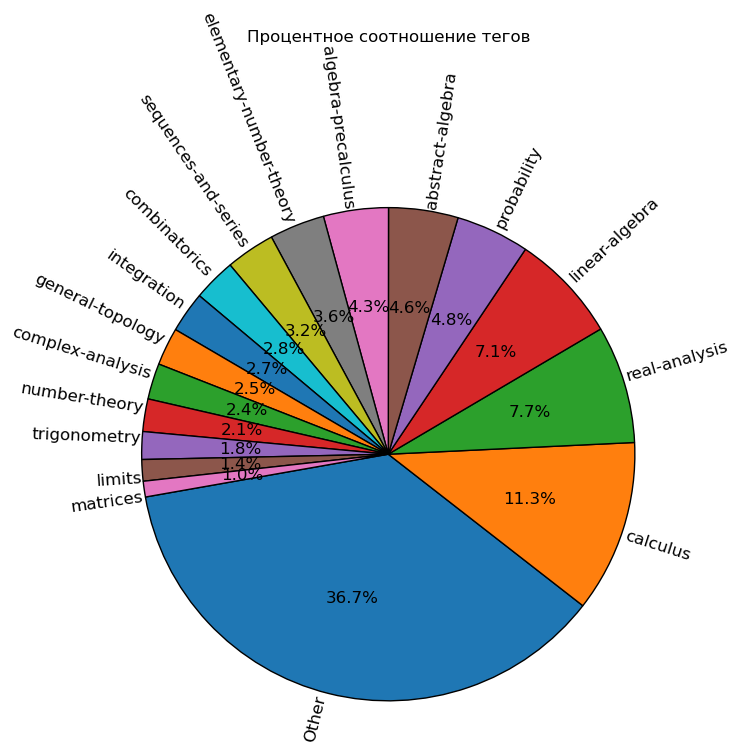

In [50]:
tag_counts = df['tags'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(tag_counts, labels=tag_counts.index, autopct='%1.1f%%', startangle=190,
        labeldistance=1,  textprops={'fontsize': 12}, rotatelabels=True,  wedgeprops={'edgecolor': 'black'})
plt.title('Процентное соотношение тегов', y=1.25)
plt.axis('equal')
plt.show()

In [19]:
df

,text_id,output_texts,input_texts,tags,augmentation,formulae_only
13875,141055,$$V^2 \;\;\text{is proportional to}\;\; (xy)^3...,V в степени 2 \;\;\text{is proportional to}\;\...,integration,all_augments,True
2995,582037,"Похоже, Эванс просто применяет определение яко...","Похоже, Эванс просто применяет определение яко...",Other,rand_delet_and_typo,False
13143,588904,"Вы только доказали, что $\overline A\cup\overl...","Вы только доказали, что $\overline А \cup\ove...",real-analysis,synonyms,False
2326,185847,"$h | d_i : d_i \to \bar B(a,r)$","h | d_ итая : d_i \rightarrow \bar Б(a,r ск...",general-topology,all_augments,True
11335,161395,$n = \sum_{n=0}^{k} x_n2^n$,n = \sum_ n=0}^ k} x_n2^n,Other,rand_delet_and_typo,True
...,...,...,...,...,...,...
3552,165659,$|f(c_1)-g(c_2)| < \varepsilon$,|f( ц 1 сккобка закрываЗтся -g( c с индексом...,real-analysis,all_augments,True
13872,430915,"Ты так близко! Обратите внимание, что поскольк...","Ты так близко! Обратите внимание, что поскольк...",integration,synonyms,False
9596,615781,"Предположим сначала, что $u_0>\xi$. Тогда реше...","Предположим сначала, что $ у с индексом 0 бол...",Other,synonyms,False
9459,51313,"$lim_n(y_n+z_n)=y+z=lim_nh(y_n,z_n)=h(y+z)$",lim_ эн ( игрию _ эн +z__ эн скобк а закрывае...,Other,all_augments,True


In [20]:
(df.tags.value_counts()/len(df))*100

tags
Other                       36.693333
calculus                    11.286667
real-analysis                7.720000
linear-algebra               7.133333
probability                  4.820000
abstract-algebra             4.553333
algebra-precalculus          4.253333
elementary-number-theory     3.620000
sequences-and-series         3.226667
combinatorics                2.806667
integration                  2.680000
general-topology             2.473333
complex-analysis             2.353333
number-theory                2.133333
trigonometry                 1.813333
limits                       1.406667
matrices                     1.026667
Name: count, dtype: float64

In [21]:
med_len = df['output_texts'].str.len().median()

In [22]:
med_len

160.5

In [23]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=int(med_len)):
        df.reset_index(drop=True, inplace=True)
        self.outputs = df["output_texts"]
        self.inputs = df["input_texts"]
        self.tags = df['tags']
        self.tokenizer = tokenizer
        self.max_len=max_len

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        # для t5-small
        item = {}
        #print(index)
        
        inputs = self.tokenizer(self.inputs[index],return_tensors='pt',
                                padding='max_length',truncation=True,
                                return_attention_mask=True,max_length=self.max_len)
        outputs = self.tokenizer(self.outputs[index],return_tensors='pt',
                                 padding='max_length',truncation=True, 
                                 return_attention_mask=True,max_length=self.max_len)
        
        item['input_ids'] = inputs['input_ids'].squeeze().to(device)
        item['attention_mask'] = inputs['attention_mask'].squeeze().to(device)
        item['labels'] = outputs['input_ids'].squeeze().to(device)
        return item
    def get_item_tag(self,index):
        return self.tags[index]

In [24]:
test_dataset=df.drop('text_id',axis=1)

In [25]:
BATCH_SIZE=40
test_dataset = CustomDataset(test_dataset, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False)

In [26]:
from tqdm.auto import tqdm
from transformers import get_scheduler

In [27]:
%%time

model.eval()
#model.to(device)

test_metrics = []
hyps = []
all_preds=[]
with torch.no_grad():
    for batch in tqdm(test_loader, desc='testing'):
        batch['input_ids']=batch['input_ids'].to(device)
        phrases = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
        hypotheses = []
        
        for tens_to_be, phrase in zip(batch['input_ids'],phrases):
            max_len = len(phrase)

            one_pred = model.generate(
                tens_to_be.unsqueeze(0),
                do_sample=True, 
                top_p=0.1, 
                num_return_sequences=1, 
                repetition_penalty=0.7,
                max_length=max_len,
                min_length=10,
            )
            hyps.append(one_pred.tolist()[0])
        hyps = tokenizer.batch_decode(hyps, skip_special_tokens=True)

        all_preds.append(hyps)
        for generated, label in zip(hyps, phrases):
            metric = Levenshtein.normalized_similarity(generated, label)
            test_metrics.append(metric)
        hyps=[]

print(test_metrics)

testing:   0%|                                                                                 | 0/375 [00:00<?, ?it/s]C:\Users\kosty\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bart\modeling_bart.py:590: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
testing:   0%|▏                                                                      | 1/375 [00:26<2:44:11, 26.34s/it]C:\Users\kosty\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\utils.py:1158: UserWarning: Unfeasible length constraints: `min_length` (10) is larger than the maximum possible length (8). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(
testing:   1%|▍                                                 

[0.9838709677419355, 0.9119496855345912, 0.6062176165803108, 0.935483870967742, 1.0, 1.0, 1.0, 0.8728323699421965, 0.7972027972027972, 0.6851851851851851, 0.6028985507246376, 0.875, 0.7403846153846154, 0.7624309392265194, 0.514018691588785, 0.7935483870967742, 0.7556818181818181, 0.9230769230769231, 0.6164383561643836, 0.6728395061728395, 0.6666666666666667, 0.8343949044585988, 1.0, 0.4832535885167464, 0.48677248677248675, 1.0, 0.9024390243902439, 0.7, 0.5949367088607596, 0.8137254901960784, 0.8590604026845637, 0.8461538461538461, 1.0, 0.9212121212121213, 0.6881720430107527, 0.5955056179775281, 0.8930817610062893, 0.5256916996047432, 0.7727272727272727, 0.9038461538461539, 0.8716216216216216, 0.5405405405405406, 0.7857142857142857, 0.8673469387755102, 0.536231884057971, 0.8278145695364238, 0.8707482993197279, 0.8993288590604027, 0.6363636363636364, 0.76, 0.8783783783783784, 0.9166666666666666, 1.0, 0.6375545851528384, 0.6094674556213018, 0.7004405286343612, 0.888268156424581, 0.8823529

In [28]:
test_average = sum(test_metrics)/len(test_metrics)
print(f"the average normalized levenshtein similarity is: {test_average}")

the average normalized levenshtein similarity is: 0.7972757105881733


In [29]:
orig_df = df

In [30]:
len(test_metrics)

15000

In [31]:
len(all_preds)

375

In [32]:
preds = [j for i in all_preds for j in i]

In [33]:
len(preds)

15000

In [34]:
data = {'prediction':preds, 'metric':test_metrics}
test_data_df = pd.DataFrame(data)

In [35]:
test_data_df

,prediction,metric
0,"$$V^2 \;\;\text{is proportional to}\;\, (xy)^3...",0.983871
1,"Похоже, Эванс просто по�именяет определение як...",0.911950
2,"Вы только доказали, что $\overline A\cup\overl...",0.606218
3,"$h | d_i: d_j \to \bar B(a,r)$",0.935484
4,$n = \sum_{n=0}^{k} x_n2^n$,1.000000
...,...,...
14995,$|f(c_1)-g(c| < \varepsilon$,0.903226
14996,"Ты так близко! Обратите внимание, что поскольк...",0.526749
14997,"Предположим сначала, что $u_0>\xi$. Тогда реше...",0.677419
14998,"$lim_n(y_n+z_n)=y+z=lim_ni(y+nh(y,z_h)=h(z)$",0.818182


In [36]:
orig_df.reset_index(inplace=True)

In [37]:
fin_df = pd.concat([orig_df, test_data_df], axis=1)

In [38]:
fin_df

,index,text_id,output_texts,input_texts,tags,augmentation,formulae_only,prediction,metric
0,13875,141055,$$V^2 \;\;\text{is proportional to}\;\; (xy)^3...,V в степени 2 \;\;\text{is proportional to}\;\...,integration,all_augments,True,"$$V^2 \;\;\text{is proportional to}\;\, (xy)^3...",0.983871
1,2995,582037,"Похоже, Эванс просто применяет определение яко...","Похоже, Эванс просто применяет определение яко...",Other,rand_delet_and_typo,False,"Похоже, Эванс просто по�именяет определение як...",0.911950
2,13143,588904,"Вы только доказали, что $\overline A\cup\overl...","Вы только доказали, что $\overline А \cup\ove...",real-analysis,synonyms,False,"Вы только доказали, что $\overline A\cup\overl...",0.606218
3,2326,185847,"$h | d_i : d_i \to \bar B(a,r)$","h | d_ итая : d_i \rightarrow \bar Б(a,r ск...",general-topology,all_augments,True,"$h | d_i: d_j \to \bar B(a,r)$",0.935484
4,11335,161395,$n = \sum_{n=0}^{k} x_n2^n$,n = \sum_ n=0}^ k} x_n2^n,Other,rand_delet_and_typo,True,$n = \sum_{n=0}^{k} x_n2^n$,1.000000
...,...,...,...,...,...,...,...,...,...
14995,3552,165659,$|f(c_1)-g(c_2)| < \varepsilon$,|f( ц 1 сккобка закрываЗтся -g( c с индексом...,real-analysis,all_augments,True,$|f(c_1)-g(c| < \varepsilon$,0.903226
14996,13872,430915,"Ты так близко! Обратите внимание, что поскольк...","Ты так близко! Обратите внимание, что поскольк...",integration,synonyms,False,"Ты так близко! Обратите внимание, что поскольк...",0.526749
14997,9596,615781,"Предположим сначала, что $u_0>\xi$. Тогда реше...","Предположим сначала, что $ у с индексом 0 бол...",Other,synonyms,False,"Предположим сначала, что $u_0>\xi$. Тогда реше...",0.677419
14998,9459,51313,"$lim_n(y_n+z_n)=y+z=lim_nh(y_n,z_n)=h(y+z)$",lim_ эн ( игрию _ эн +z__ эн скобк а закрывае...,Other,all_augments,True,"$lim_n(y_n+z_n)=y+z=lim_ni(y+nh(y,z_h)=h(z)$",0.818182


In [39]:
fin_df[fin_df['metric']<0.5]

,index,text_id,output_texts,input_texts,tags,augmentation,formulae_only,prediction,metric
23,9598,19607,$$\begin{align}\int \tan(5x)\tan(3x)\tan(2x) d...,\begin{align}\\int \tan(5x)\tan(3x)\tan(2x) dx...,calculus,rand_delet_and_typo,True,\begin{align}\int \tan(5x)\tan(3x)\int(3 x)\ta...,0.483254
24,148,814145,"Я думаю, проще всего посчитать\r\n$$ (3-\sqrt{...","Я думаю, проще всего посчитать\r\n$$ (три-\sqr...",algebra-precalculus,num2word,False,"Я думаю, проще всего посчитать\r\n$$ (3-\sqrt{...",0.486772
66,961,129306,$S(4)=1$,$S(четыре)=первый$,Other,num2word,True,$S(,0.375000
74,4128,89041,$$ \int_0^{e^2-1} \left(\left[e^{-2}/2 (x - e^...,$$ определённый интеграл от 0 в степени {e в ...,real-analysis,synonyms,True,$$ \int_0^{e^2-1} \left(\left[e^{-2}/2 (x - e^...,0.482234
77,9133,842750,Для $|n|<1$ имеем\r\n$$\r\n\lvert \binom{n+i-1...,Для $|n|<1$ имеем\r\n$$\r\n\lvert \binom{ эн +...,combinatorics,synonyms,False,Для $|n|<1$ имеем\r\n$$\r\n\lvert \binom{n+i-1...,0.454183
...,...,...,...,...,...,...,...,...,...
14959,4561,556086,"Обратите внимание, что $$ \displaystyle\int_{-...","Обратите внимание, что $$ \displaystyleопредел...",calculus,synonyms,False,"Обратите внимание, что $$ \displaystyle\int_{-...",0.460377
14967,12001,223770,Подписчик $x \mapsto 1/u$...\r\n\r\n$$\int_1^{...,Подписчик x \mapsto 1/u...\r\n\r\n\iny_1^{\\in...,calculus,all_augments,False,Подписчик $x \mapsto 1/u...$\r\n\r\n$$\int_1^{...,0.491228
14970,8248,887764,"Если мы допустим $g(x)=f(x)-x^4$, то нам даны ...",Если мы допустим g( икс )= фэ ( хэ скобки зак...,real-analysis,all_augments,False,"Если мы допустим $g(x)=f(x)-x^4$, то нам даны ...",0.361446
14984,6583,173476,$-100i$,$минус стоi$,algebra-precalculus,num2word,True,$-,0.285714


In [40]:
bad_df = fin_df[fin_df['metric']<0.7]

In [41]:
bad_df['tags'].value_counts()

tags
Other                       1310
calculus                     502
real-analysis                262
linear-algebra               253
probability                  198
algebra-precalculus          175
sequences-and-series         154
elementary-number-theory     154
abstract-algebra             149
integration                  127
combinatorics                 95
complex-analysis              95
trigonometry                  88
number-theory                 81
general-topology              74
limits                        62
matrices                      40
Name: count, dtype: int64

In [42]:
fin_df['tags'].value_counts()

tags
Other                       5504
calculus                    1693
real-analysis               1158
linear-algebra              1070
probability                  723
abstract-algebra             683
algebra-precalculus          638
elementary-number-theory     543
sequences-and-series         484
combinatorics                421
integration                  402
general-topology             371
complex-analysis             353
number-theory                320
trigonometry                 272
limits                       211
matrices                     154
Name: count, dtype: int64

In [43]:
fin_df[fin_df['metric']>0.4]['metric'].mean()

0.8126145163209183

In [44]:
fin_df['metric'].median()

0.84375

In [45]:
fin_df['metric'].std()

0.17703828442660943

In [46]:
from datetime import datetime

In [47]:
# fin_df.to_excel("inference_for_nums.xlsx")

fin_df.to_parquet(f"small_inference_for_nums{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}.parquet")

In [49]:
!conda list

# packages in environment at C:\Users\kosty\anaconda3\envs\my_env:
#
# Name                    Version                   Build  Channel
absl-py                   2.1.0                    pypi_0    pypi
accelerate                0.29.2                   pypi_0    pypi
aiohttp                   3.9.4                    pypi_0    pypi
aiosignal                 1.3.1                    pypi_0    pypi
asttokens                 2.4.1                    pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
async-timeout             4.0.3                    pypi_0    pypi
attrs                     23.2.0                   pypi_0    pypi
beautifulsoup4            4.12.3                   pypi_0    pypi
blas                      1.0                         mkl  
bottleneck                1.3.7            py39h9128911_0  
brotli                    1.0.9                h2bbff1b_8  
brotli-bin                1.0.9                h2bbff1b_8  
ca-certificates           2024